# Hidden markov model time
1. base line state
2. anticipation state
3. reward state

# GOAL: process photometry data, align it with behavioral events, and analyze it using a Hidden Markov Model (HMM) to decode states such as baseline, anticipation, and reward. 

In [14]:
import os
import numpy as np
import pandas as pd
from nptdms import TdmsFile
import matplotlib.pyplot as plt
from hmmlearn import hmm

def import_photometry_data(directory, mouse_id, day):
    filename = os.path.join(directory, f"{mouse_id}_day{day}.tdms")
    if not os.path.exists(filename):
        print(f"File {filename} does not exist.")
        return None
    try:
        tdms_file = TdmsFile.read(filename)
    except Exception as e:
        print(f"Failed to read {filename}: {e}")
        return None

    return {channel.name: channel[:] for group in tdms_file.groups() for channel in group.channels()}

def find_water_valve_rises(signal):
    return np.where(np.diff(signal > 2))[0] + 1

def load_and_preprocess_behavior_data(directory, mouse_id, day):
    filepath = os.path.join(directory, f"{mouse_id}_day{day}.lvm")
    if not os.path.exists(filepath):
        print(f"File {filepath} does not exist.")
        return None

    data = pd.read_csv(filepath, header=None)
    columns = ['time', 'odour_a', 'odour_b', 'odour_c', 'lick_data', 'water_valve']
    data.columns = columns[:len(data.columns)]
    return data.dropna(axis=1, how='all')

def process_photometry_data(directory_photometry, directory_behavior, mouse_id, day):
    sampling_rate = 500  # Hz
    pre_reward_secs, post_reward_secs = 10, 5
    baseline_pre_reward_secs = 1.5

    photometry_data = import_photometry_data(directory_photometry, mouse_id, day)
    behavior_data = load_and_preprocess_behavior_data(directory_behavior, mouse_id, day)
    if photometry_data is None or behavior_data is None:
        print(f"Failed to load data for mouse {mouse_id}.")
        return None

    reward_indices = find_water_valve_rises(behavior_data['water_valve'].values)
    pre_reward_points, post_reward_points = int(pre_reward_secs * sampling_rate), int(post_reward_secs * sampling_rate)
    baseline_pre_reward_points = int(baseline_pre_reward_secs * sampling_rate)

    ach_signals = {'PFC': [], 'HPC': []}
    for reward_index in reward_indices:
        for area, channel_name in zip(['PFC', 'HPC'], ['Voltage_0 (Filtered)', 'Voltage_1 (Filtered)']):
            if channel_name in photometry_data:
                start, end = max(reward_index//2 - pre_reward_points, 0), reward_index//2 + post_reward_points
                baseline_start = reward_index//2 - baseline_pre_reward_points
                segment = photometry_data[channel_name][start:end]
                if len(segment) == pre_reward_points + post_reward_points:
                    baseline_mean = np.mean(photometry_data[channel_name][baseline_start:reward_index//2])
                    ach_signals[area].append(segment - baseline_mean)
    return ach_signals

def extract_aligned_signals(directory_photometry, directory_behavior, mouse_ids, days_of_interest, area_of_interest):
    all_signals = []
    for mouse_id in mouse_ids:
        for day in days_of_interest:
            print(f"Processing: Mouse {mouse_id}, Day {day}")
            signals = process_photometry_data(directory_photometry, directory_behavior, mouse_id, day)
            if signals and area_of_interest in signals:
                print(f"Found signals for {area_of_interest}")
                all_signals.extend(signals[area_of_interest])  # Modified line
    if not all_signals:
        print("No signals were extracted.")
        return np.array([])
    return np.vstack(all_signals)  # Modified line for correct shape


def run_hmm_on_signals(signals):
    if signals.size == 0:
        print("No signals to process.")
        return None

    if signals.ndim == 1:
        signals = signals.reshape(-1, 1)

    model = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=100)
    model.fit(signals)
    hidden_states = model.predict(signals)

    return hidden_states

def visualize_hidden_states(signals, hidden_states):
    if hidden_states is None or len(hidden_states) == 0:
        print("No hidden states to visualize.")
        return

    plt.figure(figsize=(15, 5))

    # Define colors for each state for easier visualization
    colors = ['red', 'green', 'blue']
    state_labels = ['State 0', 'State 1', 'State 2']
    reward_time = 1500
    first_odor_time = 1000
    second_odor_time = 1300
    
    # Plot signals, coloring by state
    for state in range(3):  # Assuming 3 states
        # Find indices where hidden_states equals the current state
        state_indices = np.where(hidden_states == state)[0]

        # Plot only the segments of the signals belonging to the current state
        plt.plot(state_indices, signals[state_indices], '.', color=colors[state], label=state_labels[state], alpha=0.3)

    plt.axvline(x=reward_time, color='red', linestyle='--', label='Reward Onset')
    plt.axvline(x=first_odor_time, color='magenta', linestyle='--', label='First Odor Onset')
    plt.axvline(x=second_odor_time, color='purple', linestyle='--', label='Second Odor Onset')
    
    plt.xlabel('Time (samples)')
    plt.ylabel('Signal amplitude')
    plt.title('Signals and Decoded States Around Reward')

    # Ensure each label is only added to the legend once
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.show()

Processing: Mouse maxwell_453, Day 3
Found signals for HPC
Processing: Mouse maxwell_453, Day 4
Found signals for HPC
Processing: Mouse maxwell_453, Day 5
Found signals for HPC
Processing: Mouse maxwell_453, Day 6
Found signals for HPC
Processing: Mouse maxwell_453, Day 7
Found signals for HPC
Processing: Mouse maxwell_453, Day 8
Found signals for HPC
Processing: Mouse maxwell_453, Day 9
Found signals for HPC
Processing: Mouse maxwell_453, Day 10
Found signals for HPC
Processing: Mouse maxwell_453, Day 11
Found signals for HPC
Fitting HMM... This may take a while.


Model is not converging.  Current: 50517212.85817186 is not greater than 50531718.8959251. Delta is -14506.037753239274


HMM fitting completed.


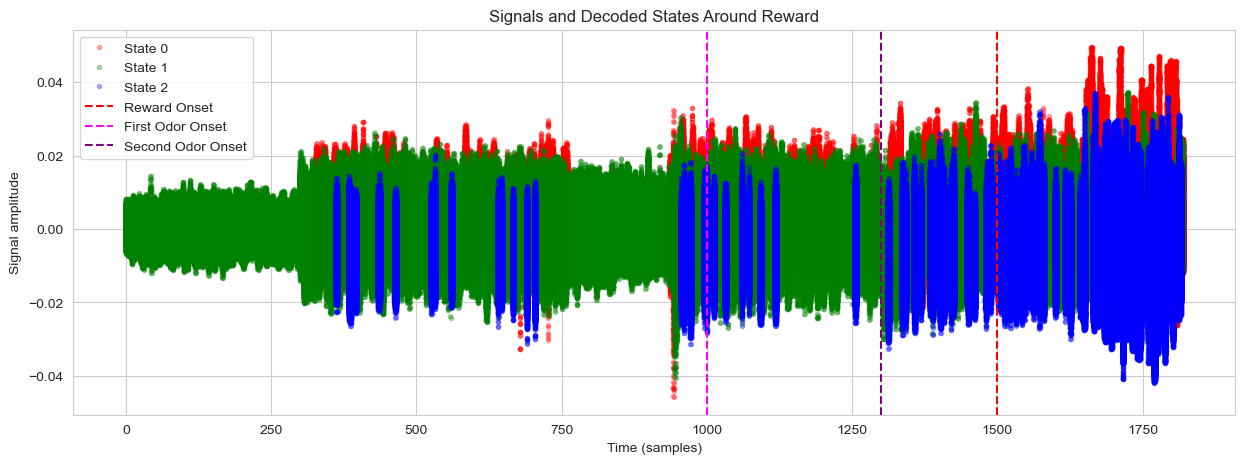

In [13]:
# Execute the analysis
directory_photometry = '/Users/chenx/Desktop/MacAskill Lab/Data/My_Rig_Data/Photometry'
directory_behavior = '/Users/chenx/Desktop/MacAskill Lab/Data/My_Rig_Data/Behaviour'
# mouse_ids = ['maxwell_452', 'maxwell_453', 'maxwell_454']
mouse_ids = ['maxwell_453']

days_of_interest = np.arange(3,12)
area_of_interest = 'HPC'

# Your execution logic remains the same
signals = extract_aligned_signals(directory_photometry, directory_behavior, mouse_ids, days_of_interest, area_of_interest)
if signals.size > 0:
    print("Fitting HMM... This may take a while.")
    hidden_states = run_hmm_on_signals(signals)
    if hidden_states is not None:
        print("HMM fitting completed.")
        visualize_hidden_states(signals, hidden_states)
    else:
        print("HMM fitting failed.")
else:
    print("No signals were extracted.")
